# Implementation Of UNET in Keras

![alt text](https://cdn-images-1.medium.com/max/800/1*OkUrpDD6I0FpugA_bbYBJQ.png)

## Importing Libraries

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

## Preprocessing

In [0]:
# Setting up some parameters
height = 128
width = 128
border = 5

In [36]:
images = next(os.walk("images"))[2] # list of names all images in the given path
print("No. of images = ", len(images))

No. of images =  4000


In [0]:
X = np.zeros((len(images), height, width, 1), dtype=np.float32)
y = np.zeros((len(images), height, width, 1), dtype=np.float32)

In [38]:
for n,image in tqdm_notebook(enumerate(images), total=len(images)):
    # Load images
    img = img_to_array(load_img("images/"+image,color_mode="grayscale"))
    x_img = resize(img, (128, 128, 1))
    # Load masks
    mask = img_to_array(load_img("masks/"+image, color_mode="grayscale"))
    mask = resize(mask, (128, 128, 1))
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

## Train Test Split Of Data

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

## Display Random Images

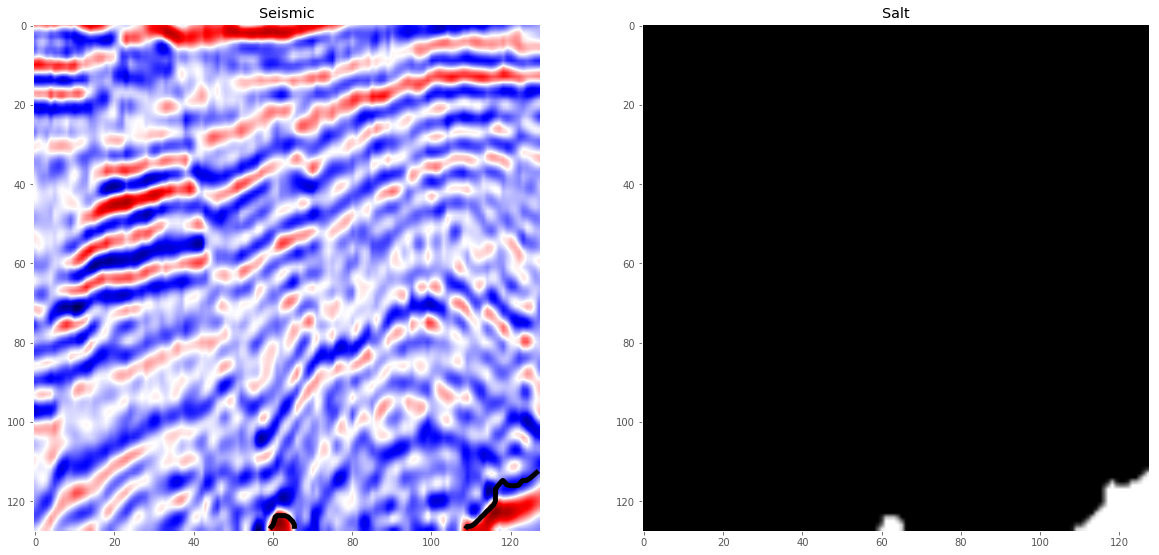

In [40]:
indexOfX = random.randint(0, len(X_train))
has_mask = y_train[indexOfX].max() > 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[indexOfX, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask:
    ax1.contour(y_train[indexOfX].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')
ax1.grid(False)
ax2.imshow(y_train[indexOfX].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')
ax2.grid(False)

In [0]:
def conv2dBlock(input_tensor, n_filters, kernel_size = 3):
  x = None
  for i in range(2):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
  return x

## Model Architecture

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1):
#     Encoder
    c1 = conv2dBlock(input_img, n_filters * 1, kernel_size = 3)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2dBlock(p1, n_filters * 2, kernel_size = 3)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2dBlock(p2, n_filters * 4, kernel_size = 3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2dBlock(p3, n_filters * 8, kernel_size = 3)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2dBlock(p4, n_filters = n_filters * 16, kernel_size = 3)
    
#     Decoder
#     Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2dBlock(u6, n_filters * 8, kernel_size = 3)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2dBlock(u7, n_filters * 4, kernel_size = 3)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2dBlock(u8, n_filters * 2, kernel_size = 3)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2dBlock(u9, n_filters * 1, kernel_size = 3)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
input_img = Input((height, width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [44]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 128, 128, 16) 64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 128, 128, 16) 0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
max_poolin

## Setting Callback Functions

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

## Training The Model

In [46]:
results = model.fit(X_train, y_train, batch_size=32, epochs=20, callbacks=callbacks,validation_data=(X_valid, y_valid))

Train on 3600 samples, validate on 400 samples
Epoch 1/20
3600/3600 [==============================] - 12s 3ms/step - loss: 0.4615 - acc: 0.8087 - val_loss: 0.7891 - val_acc: 0.7168

Epoch 00001: val_loss improved from inf to 0.78909, saving model to model-tgs-salt.h5
Epoch 2/20
3600/3600 [==============================] - 10s 3ms/step - loss: 0.3297 - acc: 0.8705 - val_loss: 0.4080 - val_acc: 0.8207

Epoch 00002: val_loss improved from 0.78909 to 0.40803, saving model to model-tgs-salt.h5
Epoch 3/20
3600/3600 [==============================] - 10s 3ms/step - loss: 0.2890 - acc: 0.8843 - val_loss: 0.6050 - val_acc: 0.7735

Epoch 00003: val_loss did not improve from 0.40803
Epoch 4/20
3600/3600 [==============================] - 10s 3ms/step - loss: 0.2749 - acc: 0.8888 - val_loss: 0.3443 - val_acc: 0.8607

Epoch 00004: val_loss improved from 0.40803 to 0.34433, saving model to model-tgs-salt.h5
Epoch 5/20
3600/3600 [==============================] - 10s 3ms/step - loss: 0.2588 - acc: 0

## Ploting Los

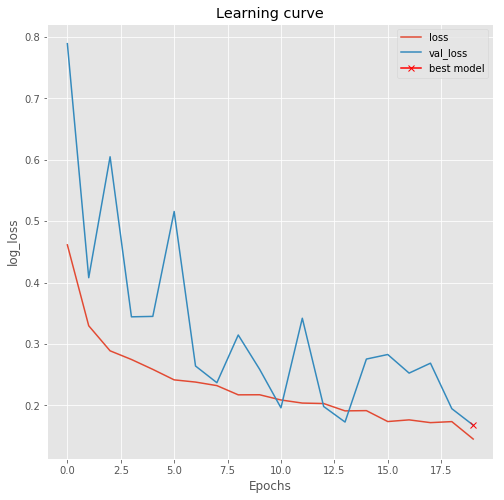

In [47]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## Load The Model

In [0]:
model.load_weights('model-tgs-salt.h5')

## Predict The Result

In [49]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

400/400 [==============================] - 0s 663us/step


In [0]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

## Some Helper Functions

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')
    ax[0].grid(False)

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')
    ax[1].grid(False)

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    ax[2].grid(False)
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');
    ax[3].grid(False)

## Display Final Results

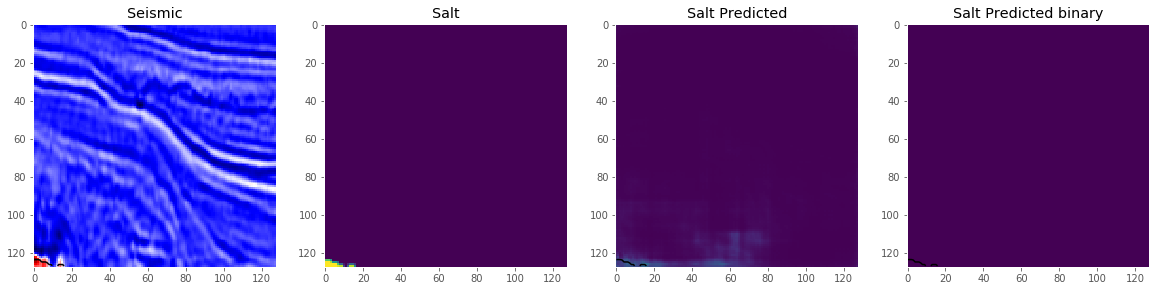

In [60]:
plot_sample(X_train, y_train, preds_train, preds_train_t)


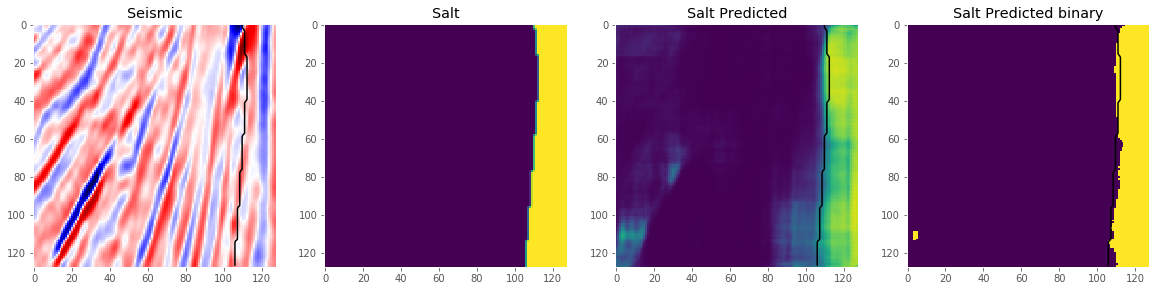

In [61]:
plot_sample(X_train, y_train, preds_train, preds_train_t)